In [25]:
from textblob import TextBlob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers


from warnings import filterwarnings
filterwarnings('ignore')


Using TensorFlow backend.


In [1]:
import pandas as pd
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train_data = train.copy()
test_data = test.copy()

In [2]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
train_data["label"].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [5]:
##
train_data["label"].replace(1,value="fake",inplace=True)
train_data["label"].replace(0,value="true",inplace=True)

In [6]:
train_data = train_data.set_index('id', drop = True)
train_data.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,fake
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,true
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",fake
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,fake
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,fake


In [7]:
#checking missing values
train_data.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
test_data=test_data.fillna(' ')
train_data=train_data.fillna(' ')

In [9]:
train_data.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

In [10]:
df=pd.DataFrame()
df["text"]=train_data["text"]
df["result"]=train_data["label"]

In [11]:
df.head()

,text,result
id,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,fake
1,Ever get the feeling your life circles the rou...,true
2,"Why the Truth Might Get You Fired October 29, ...",fake
3,Videos 15 Civilians Killed In Single US Airstr...,fake
4,Print \nAn Iranian woman has been sentenced to...,fake


In [12]:
#Checking for outliers
df["length"] = df["text"].str.len()
df.head()

,text,result,length
id,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,fake,4930
1,Ever get the feeling your life circles the rou...,true,4160
2,"Why the Truth Might Get You Fired October 29, ...",fake,7692
3,Videos 15 Civilians Killed In Single US Airstr...,fake,3237
4,Print \nAn Iranian woman has been sentenced to...,fake,938


In [13]:
#checking for minumum,maximum and average length

min(df['length']), max(df['length']), round(sum(df['length'])/len(df['length']))

(1, 142961, 4544)

In [14]:
# dropping the outliers which are less than 50 word
df = df.drop(df['text'][df['length'] < 50].index, axis = 0)

In [15]:
min(df['length']), max(df['length']), round(sum(df['length'])/len(df['length']))

(50, 142961, 4598)

In [16]:
df.head()

,text,result,length
id,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,fake,4930
1,Ever get the feeling your life circles the rou...,true,4160
2,"Why the Truth Might Get You Fired October 29, ...",fake,7692
3,Videos 15 Civilians Killed In Single US Airstr...,fake,3237
4,Print \nAn Iranian woman has been sentenced to...,fake,938


# Text Preprocessing

In [17]:
#upper-lower transform
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#punctuations
df['text'] = df['text'].str.replace('[^\w\s]','')
#numbers
df['text'] = df['text'].str.replace('\d','')
#stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
#deleting sparse words
sil = pd.Series(' '.join(df['text']).split()).value_counts()[-1000:]
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))
#lemmi
from textblob import Word
#nltk.download('wordnet')
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [18]:
df.head()

,text,result,length
id,,,
0,house dem aide didnt even see comeys letter ja...,fake,4930
1,ever get feeling life circle roundabout rather...,true,4160
2,truth might get fired october tension intellig...,fake,7692
3,video civilian killed single u airstrike ident...,fake,3237
4,print iranian woman sentenced six year prison ...,fake,938


In [19]:
# Word Cloud Visualization

In [20]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [21]:
text = " ".join(i for i in df.text)

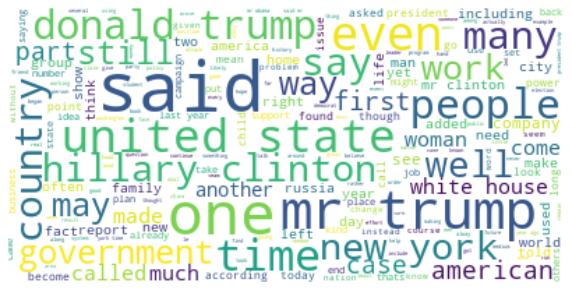

In [22]:
wordcloud = WordCloud(max_font_size = 50, 
                     background_color = "white").generate(text)
plt.figure(figsize = [10,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [23]:
# Train-Test split

In [26]:
train_x,test_x,train_y,test_y=model_selection.train_test_split(df["text"],
                                                               df["result"],
                                                               random_state=1)

In [27]:
train_x.head()

id
12877    via ap donald trump elected america th preside...
15513    oh loretta ill bet ag loretta lynch shaking bo...
3434     cairo egypt czar thought job estimated much en...
16951    store hacking democracy creator exposed hillar...
6147     license dmca people object water fluoridation ...
Name: text, dtype: object

In [28]:
encoder =preprocessing.LabelEncoder()

In [29]:
train_y=encoder.fit_transform(train_y)
test_y=encoder.fit_transform(test_y)

In [30]:
train_y[0:5]

array([0, 0, 1, 0, 0])

In [31]:
test_y[0:5]

array([1, 1, 0, 0, 0])

# TF-IDF

In [32]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [33]:
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [34]:
x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
# Logistic Regression

In [36]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(loj_model, 
                                           x_test_tf_idf_word, 
                                           test_y, 
                                           cv = 10).mean()

print("Word-Level TF-IDF Accuracy Rate:", accuracy)

Word-Level TF-IDF Accuracy Rate: 0.9233344202559968
